In [1]:
import numpy as np
import scipy
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [8]:
image_path = './'
celeba_train = torchvision.datasets.CelebA(root=image_path, split='train', download=False, target_type='attr')
celeba_valid = torchvision.datasets.CelebA(root=image_path, split='valid', download=False, target_type='attr')
celeba_test = torchvision.datasets.CelebA(root=image_path, split='test', download=False, target_type='attr')

In [9]:
print('Train set:', len(celeba_train))
print('Validation set:', len(celeba_valid))
print('Test set:', len(celeba_test))

Train set: 162770
Validation set: 19867
Test set: 19962


In [10]:
celeba_train[0][0].width

178

Data Augmentation Techniques

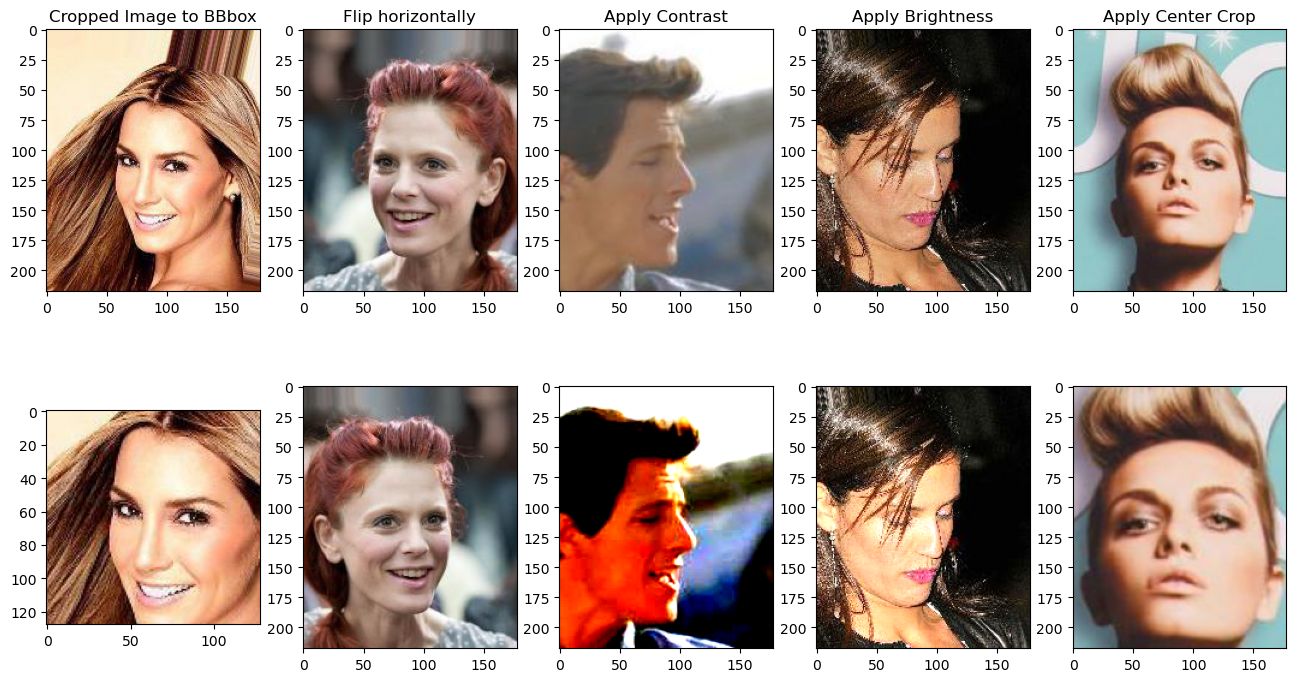

In [11]:
fig = plt.figure(figsize=(16, 8.5))
## Cropping to a bounding box
ax = fig.add_subplot(2, 5, 1)
img, attr = celeba_train[0]
ax.imshow(img)
ax.set_title('Cropped Image to BBbox')
ax = fig.add_subplot(2, 5, 6)
cropped_image = transforms.functional.crop(img, 50, 20, 128, 128)
ax.imshow(cropped_image)

### flipping horizontally
ax = fig.add_subplot(2, 5, 2)
img, attr = celeba_train[1]
ax.imshow(img)
ax.set_title('Flip horizontally')
ax = fig.add_subplot(2, 5, 7)
flipped_image = transforms.functional.hflip(img)
ax.imshow(flipped_image)

### Adjust contrast
ax = fig.add_subplot(2, 5, 3)
img, attr = celeba_train[2]
ax.imshow(img)
ax.set_title('Apply Contrast')
ax = fig.add_subplot(2, 5, 8)
contrast_image = transforms.functional.adjust_contrast(img, contrast_factor=5)
ax.imshow(contrast_image)

## Apply Brightness
ax = fig.add_subplot(2, 5, 4)
img, attr = celeba_train[3]
ax.imshow(img)
ax.set_title('Apply Brightness')
ax = fig.add_subplot(2, 5, 9)
cropped_image = transforms.functional.adjust_brightness(img, brightness_factor=1.3)
ax.imshow(cropped_image)

## Apply Center Crop
ax = fig.add_subplot(2, 5, 5)
img, attr = celeba_train[4]
ax.imshow(img)
ax.set_title('Apply Center Crop')
ax = fig.add_subplot(2, 5, 10)
center_image = transforms.functional.center_crop(img, [0.7*218, 0.7*178])
cropped_image = transforms.functional.resize(center_image, [218, 178])
ax.imshow(cropped_image)

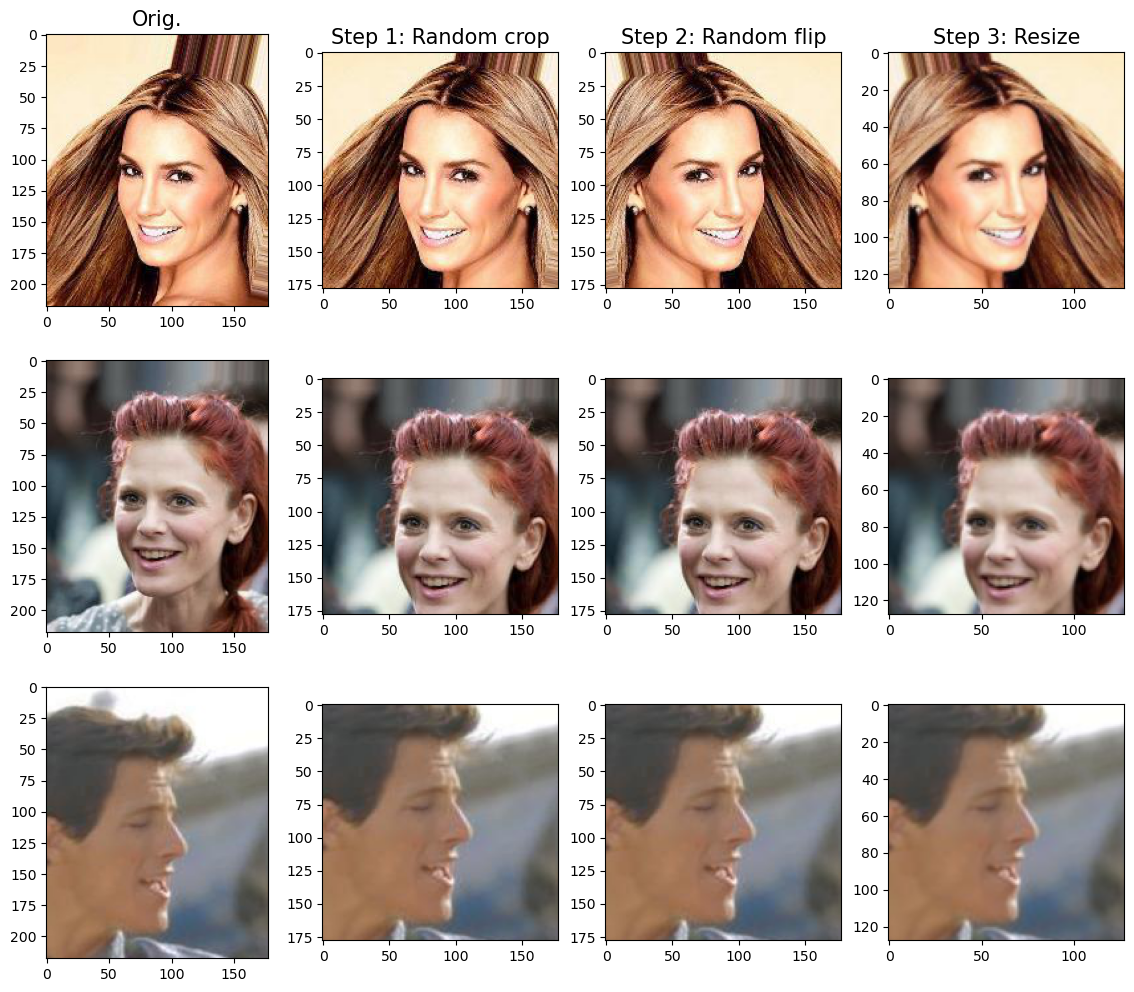

In [12]:
torch.manual_seed(1)
fig = plt.figure(figsize=(14, 12))
for i, (img, attr) in enumerate(celeba_train):

  ax = fig.add_subplot(3, 4, i*4+1)
  ax.imshow(img)
  if i == 0:
    ax.set_title('Orig.', size=15)
  ax = fig.add_subplot(3, 4, i*4+2)
  img_transform = transforms.Compose([transforms.RandomCrop([178, 178])])
  img_cropped = img_transform(img)
  ax.imshow(img_cropped)
  if i == 0:
    ax.set_title('Step 1: Random crop', size=15)
  ax = fig.add_subplot(3, 4, i*4+3)
  img_transform = transforms.Compose([transforms.RandomHorizontalFlip()])
  img_flip = img_transform(img_cropped)
  ax.imshow(img_flip)
  if i == 0:
    ax.set_title('Step 2: Random flip', size=15)

  ax = fig.add_subplot(3, 4, i*4+4)
  img_resized = transforms.functional.resize(img_flip, size=(128, 128))
  ax.imshow(img_resized)
  if i == 0:
      ax.set_title('Step 3: Resize', size=15)
  if i == 2:
    break

In [14]:
get_smile = lambda attr: attr[18]
get_smile(attr)

tensor(0)

In [15]:
transform_train = transforms.Compose([
                              transforms.RandomCrop([178, 178]),
                              transforms.RandomHorizontalFlip(),
                              transforms.Resize([64, 64]),
                              transforms.ToTensor()
])

In [16]:
torch.manual_seed(42)
## transform for the train data
transform_train_dataset = torchvision.datasets.CelebA(root=image_path, split='train', download=False,
                                                       target_type='attr', transform=transform_train, target_transform=get_smile)
## transform for the validation/tst data
transform = transforms.Compose([
                              transforms.CenterCrop([178, 178]),
                              transforms.Resize([64, 64]),
                              transforms.ToTensor()
])

## Create a DataLoader
data_loader = DataLoader(transform_train_dataset, batch_size=2)


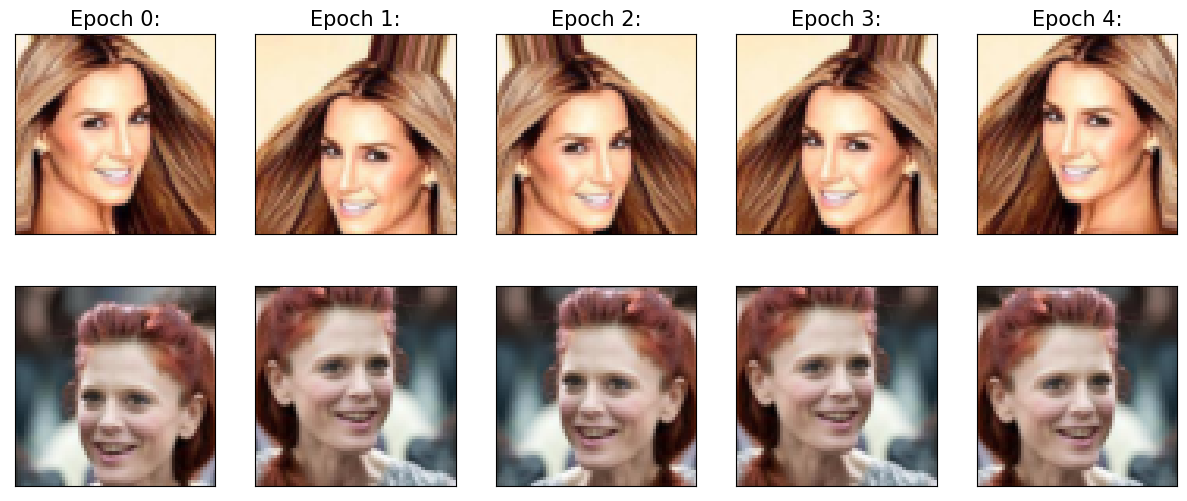

In [17]:
torch.manual_seed(42)

num_epochs = 5
fig = plt.figure(figsize=(15, 6))
for j in range(num_epochs):
  img_batch, label_batch = next(iter(data_loader))
  img = img_batch[0]
  ax = fig.add_subplot(2, 5, j+1)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.set_title(f'Epoch {j}:', size=15)
  ax.imshow(img.permute(1, 2, 0))


  img = img_batch[1]
  ax = fig.add_subplot(2, 5, j+6)
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(img.permute(1, 2, 0))

plt.show()

In [18]:
transform_valid_dataset = torchvision.datasets.CelebA(root=image_path, split='valid', download=False,
                                                       target_type='attr', transform=transform, target_transform=get_smile)

transform_test_dataset = torchvision.datasets.CelebA(root=image_path, split='test', download=False,
                                                       target_type='attr', transform=transform, target_transform=get_smile)

In [19]:
### Train Model with a small subset of the dataset // 16000 train data and 1000 validation data

from torch.utils.data import Subset

train_dataset = Subset(transform_train_dataset, torch.arange(16000))
valid_dataset = Subset(transform_valid_dataset, torch.arange(1000))

print('Train set:', len(train_dataset))
print('Validation set:', len(valid_dataset))


Train set: 16000
Validation set: 1000


In [20]:
torch.manual_seed(0)

batch_size = 32

train_dl = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
valid_dl = DataLoader(valid_dataset, shuffle=False, batch_size=batch_size)
test_dl = DataLoader(transform_test_dataset, shuffle=False, batch_size=batch_size)

### Training the Dataset

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [42]:
model = nn.Sequential()
model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels= 32,
                                    kernel_size=3, padding=1))

model.add_module('relu1', nn.ReLU())
model.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model.add_module('conv2', nn.Conv2d(in_channels=32, out_channels= 64,
                                    kernel_size=3, padding=1))
model.add_module('relu2', nn.ReLU())
model.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model.add_module('dropout-1', nn.Dropout(p=0.2))
model.add_module('conv3', nn.Conv2d(in_channels=64, out_channels= 128,
                                    kernel_size=3, padding=1))
model.add_module('relu3', nn.ReLU())
model.add_module('pool3', nn.MaxPool2d(kernel_size=2))
model.add_module('conv4', nn.Conv2d(in_channels=128, out_channels= 256,
                                    kernel_size=3, padding=1))
model.add_module('relu4', nn.ReLU())
model.add_module('pool4', nn.AvgPool2d(kernel_size=8))
model.add_module('flatten', nn.Flatten())

model.add_module('fc', nn.Linear(256, 1))
model.add_module('sigmoid', nn.Sigmoid())
# model = model.to(device=device)

In [23]:
x = torch.ones((4, 3, 64, 64), device=device)
model(x).shape

torch.Size([4, 1])

In [24]:
x = torch.ones((4, 3, 64, 64), device=device)
model(x).shape

torch.Size([4, 1])

In [25]:
x = torch.ones((4, 3, 64, 64), device=device)
model(x).shape

torch.Size([4, 1])

In [26]:
x = torch.ones((4, 3, 64, 64), device= device)
model(x)

tensor([[0.4839],
        [0.4839],
        [0.4841],
        [0.4837]], grad_fn=<SigmoidBackward0>)

In [27]:
model

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout-1): Dropout(p=0.2, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (pool4): AvgPool2d(kernel_size=8, stride=8, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## Compile Model

In [43]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [44]:
def train_model(model, num_epochs, train_dl, valid_dl):

  loss_hist_train = [0]*num_epochs
  accuracy_hist_train = [0]*num_epochs
  loss_hist_valid = [0]*num_epochs
  accuracy_hist_valid = [0]*num_epochs
  for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_dl:
      # print('y_batch', y_batch.shape)
      y_batch = y_batch.unsqueeze(1).float()  # Reshape to [batch_size, 1]
      # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
      pred = model(x_batch).float()
      loss = loss_fn(pred, y_batch)
      loss.backward()

      optimizer.step()
      optimizer.zero_grad()

      loss_hist_train[epoch] += loss.item() * y_batch.size(0)
      is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
      accuracy_hist_train[epoch] += is_correct.sum()

    loss_hist_train[epoch] /= len(train_dl.dataset)
    accuracy_hist_train[epoch] /= len(train_dl.dataset)

    model.eval()
    with torch.no_grad():
      
      for x_batch, y_batch in valid_dl:
        # x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_batch = y_batch.unsqueeze(1).float()
        pred = model(x_batch).float()
        loss = loss_fn(pred, y_batch)

        loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist_valid[epoch] += is_correct.sum()

    loss_hist_valid[epoch] /= len(valid_dl.dataset)
    accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

    print(f'Epoch {epoch+1} accuracy: '
    f'{accuracy_hist_train[epoch]:.4f} val_accuracy: '
    f'{accuracy_hist_valid[epoch]:.4f}')

  return loss_hist_train, loss_hist_valid, \
  accuracy_hist_train, accuracy_hist_valid

In [45]:
torch.manual_seed(1)
num_epochs = 20
hist = train_model(model, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 19.6360 val_accuracy: 19.0800
Epoch 2 accuracy: 19.6360 val_accuracy: 19.0800
Epoch 3 accuracy: 19.6360 val_accuracy: 19.0800


KeyboardInterrupt: 

In [46]:
accuracy_test = 0
model.eval()
with torch.no_grad():
  for x_batch, y_batch in test_dl:
    pred = model(x_batch)[:, 0]
    is_correct = ((pred>=0.5).float() == y_batch).float()
    accuracy_test += is_correct.sum()
accuracy_test /= len(test_dl.dataset)
print(f'Test accuracy: {accuracy_test:.4f}')

Test accuracy: 0.7804


In [52]:
preds = model(x_batch)[:, 0] 
preds

tensor([0.4678, 0.2127, 0.9056, 0.8754, 0.3725, 0.5367, 0.8753, 0.2738, 0.7512,
        0.4140, 0.1795, 0.0714, 0.0258, 0.6448, 0.0534, 0.1724, 0.5096, 0.6557,
        0.7847, 0.8266, 0.9268, 0.6303, 0.1233, 0.1770, 0.8891, 0.4938],
       grad_fn=<SelectBackward0>)

In [53]:
y_batch

tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
        1, 1])

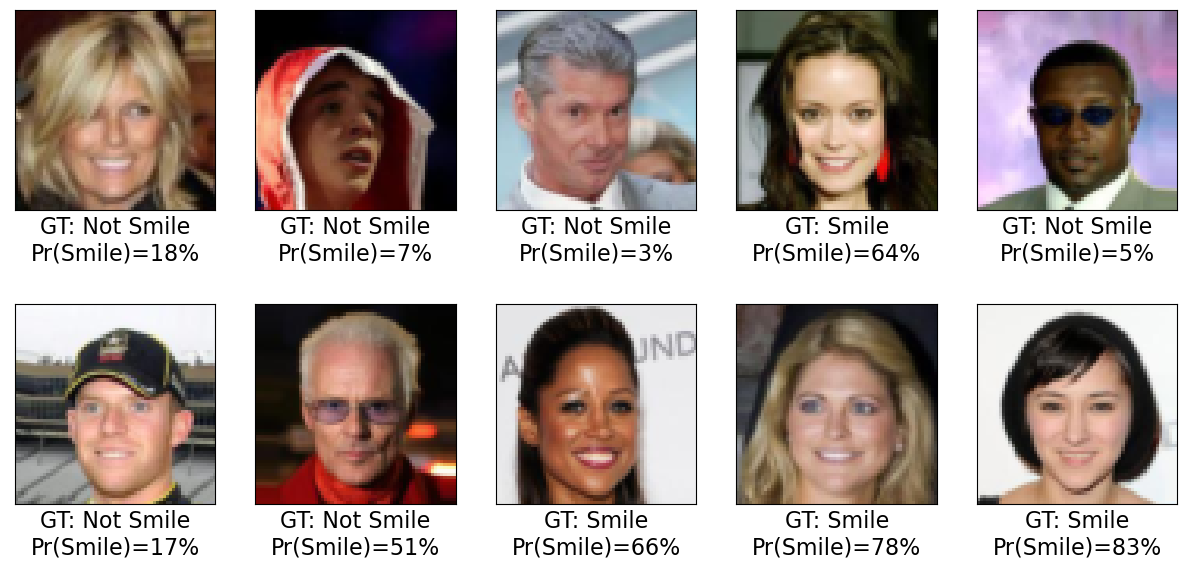

In [54]:
pred = model(x_batch)[:, 0] * 100
fig = plt.figure(figsize=(15, 7))
for j in range(10, 20):
    ax = fig.add_subplot(2, 5, j-10+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(x_batch[j].permute(1, 2, 0))
    if y_batch[j] == 1:
        label='Smile'
    else:
        label = 'Not Smile'
    ax.text(
    0.5, -0.15,
    f'GT: {label:s}\nPr(Smile)={pred[j]:.0f}%',
    size=16,
    horizontalalignment='center',
    verticalalignment='center',
    transform=ax.transAxes
    )